# Exploring transfer learning - part4

Bertrand Thia (bt2513)

This time, we are going to work with the network DenseNet121.

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from keras.preprocessing import image
from keras.applications import DenseNet121
from keras.utils import to_categorical

np.random.seed(0)

Using TensorFlow backend.


# Loading the data and data preprocessing

In [2]:
train_labels = pd.read_csv('../train.csv')

### Splitting into training set and validation set 

In [3]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

In [4]:
print('Train size: %d \t Validation size: %d' %(len(train_set), len(valid_set)))

Train size: 901 	 Validation size: 226


In [5]:
train_set['label'].value_counts()

normal       280
bacterial    280
viral        280
covid         61
Name: label, dtype: int64

### Standardization

Let's load and standardized our data. To address the overfitting issue, we are going to use data augmentation here. This will allow us to increase the size of our dataset, but also make the classification more challenging. Since the network is deep, we are going to use aggresive modifications:

In [6]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True, 
                                  rotation_range= 20,
                                  horizontal_flip= True)

val_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)

Let's use the same parameters as previously:

In [7]:
BATCH_SIZE = 32
W = 312
H = 251

X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= '../train2/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (H, W),
                                            batch_size= BATCH_SIZE, 
                                            shuffle= False)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train2/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (H, W),
                                        batch_size= BATCH_SIZE, 
                                        shuffle= False)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are going to use the network ResNet50 and pre-trained weights from the ImageNet dataset:

In [8]:
model = DenseNet121(include_top=False, weights='imagenet')

As it is very expansive to run the whole network, we are going to only do it once and save the output at the end of the pre-trained part of the network. We will then train fully-connected layers for the top layers of the model.

In [9]:
bottleneck_features_train = model.predict_generator(X_train, steps= len(train_set) // BATCH_SIZE)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_val = model.predict_generator(X_val, steps= len(valid_set) // BATCH_SIZE)
np.save(open('bottleneck_features_val.npy', 'wb'), bottleneck_features_val)

### Training the top layers 

In [10]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_y = to_categorical(train_set['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}).values[:-5])

validation_data = np.load(open('bottleneck_features_val.npy', 'rb'))
validation_y = to_categorical(valid_set['label'].map({'bacterial': 0, 'covid': 1, 
                                                     'normal': 2, 'viral': 3}).values[:-2])

In [11]:
print('Size of the training: %d \t labels: %d' %(len(train_data), len(train_y)))
print('Size of the validation: %d \t labels: %d' %(len(validation_data), len(validation_y)))

Size of the training: 896 	 labels: 896
Size of the validation: 224 	 labels: 224


Since we are using batches of data, we don't end up with the whole dataset, but this will allow to speed up the process.

Since this network is very deep and different from the previous one, we are going to modify our fully connected layers here. We obtained satisfying results with the following structure:

In [12]:
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(units= 128, activation= 'relu')) 
top_model.add(Dropout(0.5)) 
top_model.add(Dense(units= 64, activation= 'relu'))
top_model.add(Dropout(0.3)) 
top_model.add(Dense(units= 4, activation= 'softmax'))

top_model.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(lr= 1e-4), 
              metrics = ['accuracy'])

In [13]:
epochs= 70
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 3)
filepath="./weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, period= 1)

Since our dataset is imbalanced, we are going to use class weigthing to address the issue:

In [14]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [15]:
hist = top_model.fit(train_data, train_y,
                 epochs= epochs, 
                 batch_size = BATCH_SIZE,
                 verbose= 1, 
                 validation_data = (validation_data, validation_y),
                 class_weight= class_weight,
                 callbacks= [checkpoint])

Train on 896 samples, validate on 224 samples
Epoch 1/70
896/896 [==============================] - 2s 3ms/step - loss: 1.8245 - accuracy: 0.3806 - val_loss: 1.0529 - val_accuracy: 0.5670

Epoch 00001: saving model to ./weights/weights-improvement-01-0.57.hdf5
Epoch 2/70
896/896 [==============================] - 2s 3ms/step - loss: 1.1018 - accuracy: 0.5134 - val_loss: 0.7825 - val_accuracy: 0.6562

Epoch 00002: saving model to ./weights/weights-improvement-02-0.66.hdf5
Epoch 3/70
896/896 [==============================] - 2s 3ms/step - loss: 1.0042 - accuracy: 0.5681 - val_loss: 0.8037 - val_accuracy: 0.6250

Epoch 00003: saving model to ./weights/weights-improvement-03-0.62.hdf5
Epoch 4/70
896/896 [==============================] - 2s 2ms/step - loss: 0.9574 - accuracy: 0.6004 - val_loss: 0.7222 - val_accuracy: 0.7009

Epoch 00004: saving model to ./weights/weights-improvement-04-0.70.hdf5
Epoch 5/70
896/896 [==============================] - 2s 2ms/step - loss: 0.8650 - accuracy: 0

Epoch 39/70
896/896 [==============================] - 2s 2ms/step - loss: 0.2202 - accuracy: 0.8962 - val_loss: 0.6074 - val_accuracy: 0.7455

Epoch 00039: saving model to ./weights/weights-improvement-39-0.75.hdf5
Epoch 40/70
896/896 [==============================] - 2s 3ms/step - loss: 0.2403 - accuracy: 0.8806 - val_loss: 0.5500 - val_accuracy: 0.7723

Epoch 00040: saving model to ./weights/weights-improvement-40-0.77.hdf5
Epoch 41/70
896/896 [==============================] - 2s 2ms/step - loss: 0.2538 - accuracy: 0.8795 - val_loss: 0.5396 - val_accuracy: 0.7723

Epoch 00041: saving model to ./weights/weights-improvement-41-0.77.hdf5
Epoch 42/70
896/896 [==============================] - 2s 2ms/step - loss: 0.2248 - accuracy: 0.8862 - val_loss: 0.5990 - val_accuracy: 0.7634

Epoch 00042: saving model to ./weights/weights-improvement-42-0.76.hdf5
Epoch 43/70
896/896 [==============================] - 2s 2ms/step - loss: 0.2350 - accuracy: 0.8873 - val_loss: 0.6617 - val_accuracy: 

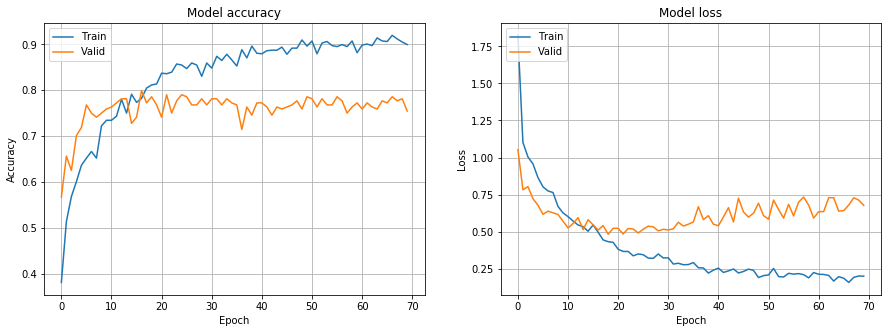

In [16]:
# Plotting the training curves

fig, axs = plt.subplots(1, 2, figsize= (15, 5))

# Plot training & validation accuracy values
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Valid'], loc='upper left')
axs[0].grid()

# Plot training & validation loss values
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(['Train', 'Valid'], loc='upper left')
plt.show()

### Evaluating our model

In [94]:
# Loading the best weights
top_model.load_weights("./weights/weights-improvement-17-0.80.hdf5")

In [95]:
evaluation = top_model.evaluate(validation_data, validation_y)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

224/224 [==============================] - 0s 928us/step
Accuracy on the validation set: 0.799


In [96]:
pred = top_model.predict(validation_data)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([1, 3, 0, 3, 2, 2, 0, 0, 3, 3])

In [97]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [98]:
y_val = valid_set['label'].map(X_val.class_indices).values

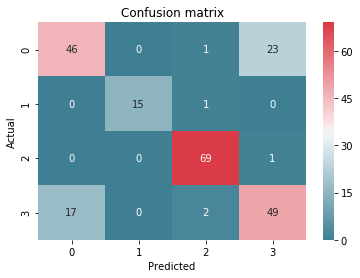

In [100]:
data = {'y_val': y_val[:-2], 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [101]:
print(classification_report(y_val[:-2], y_pred))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69        70
           1       1.00      0.94      0.97        16
           2       0.95      0.99      0.97        70
           3       0.67      0.72      0.70        68

    accuracy                           0.80       224
   macro avg       0.84      0.83      0.83       224
weighted avg       0.80      0.80      0.80       224



We didn't manage to have better results than with VGG16 in terms of overall accuracy. The performances at classifying the Covid and normal cases are higher though.

# Fine-tuning the top layers of the network

Since we were able to get nice performances with the DenseNet121 network, let's try to fine-tune the top layers to see if we can get top performances.

In [77]:
pretrained_model = DenseNet121(include_top=False, weights='imagenet', input_shape= (H, W, 3))

In [78]:
model = Model(input= pretrained_model.input, output= top_model(pretrained_model.output))

/Users/bertrandthia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [79]:
# Freezing all the blocks but the last one
for layer in model.layers[:418]:
    layer.trainable = False

pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable']).tail(15)

,layer,trainable
413,conv5_block15_1_conv,False
414,conv5_block15_1_bn,False
415,conv5_block15_1_relu,False
416,conv5_block15_2_conv,False
417,conv5_block15_concat,False
418,conv5_block16_0_bn,True
419,conv5_block16_0_relu,True
420,conv5_block16_1_conv,True
421,conv5_block16_1_bn,True
422,conv5_block16_1_relu,True


In [80]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True, 
                                  rotation_range= 20,
                                  horizontal_flip= True)

X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= '../train2/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (H, W),
                                            batch_size= BATCH_SIZE, 
                                            shuffle= False)

Found 901 validated image filenames belonging to 4 classes.


In [81]:
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

### Training

In [29]:
epochs= 5

filepath="./tuning/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, period= 1)

In [30]:
hist = model.fit_generator(X_train,
                           epochs= epochs, 
                           steps_per_epoch= len(train_set) // BATCH_SIZE,
                           verbose= 1, 
                           validation_data = X_val,
                           validation_steps= len(valid_set) // BATCH_SIZE,
                           class_weight= class_weight,
                           callbacks= [checkpoint])

Epoch 1/5
28/28 [==============================] - 196s 7s/step - loss: 0.5719 - accuracy: 0.7546 - val_loss: 0.2088 - val_accuracy: 0.8583

Epoch 00001: saving model to ./tuning/weights-improvement-01-0.86.hdf5
Epoch 2/5
28/28 [==============================] - 188s 7s/step - loss: 0.4378 - accuracy: 0.7975 - val_loss: 0.2946 - val_accuracy: 0.8479

Epoch 00002: saving model to ./tuning/weights-improvement-02-0.85.hdf5
Epoch 3/5
28/28 [==============================] - 181s 6s/step - loss: 0.4423 - accuracy: 0.7992 - val_loss: 0.2667 - val_accuracy: 0.8621

Epoch 00003: saving model to ./tuning/weights-improvement-03-0.86.hdf5
Epoch 4/5
28/28 [==============================] - 191s 7s/step - loss: 0.4169 - accuracy: 0.8036 - val_loss: 0.4136 - val_accuracy: 0.8647

Epoch 00004: saving model to ./tuning/weights-improvement-04-0.86.hdf5
Epoch 5/5
28/28 [==============================] - 183s 7s/step - loss: 0.3968 - accuracy: 0.8124 - val_loss: 0.3117 - val_accuracy: 0.8724

Epoch 00005

The results of the training look better than previously. Fine-tuning the top layers led to better performances!

### Evaluating our final model

In [82]:
# Loading the best weights
model.load_weights("./tuning/weights-improvement-05-0.87.hdf5")

In [83]:
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train2/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (H, W),
                                        batch_size= BATCH_SIZE, 
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [84]:
evaluation = model.evaluate_generator(X_val2)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.864


--- 

# Appendix

### Looking into the output of the model before fine-tuning the top layers

This code allows to get the predictions from our model before fine-tuning the last block, with just the training of the classifier part:

In [60]:
model = DenseNet121(include_top=False, weights='imagenet')

bottleneck_features_test = model.predict_generator(test_gen(X_test),steps= len(test_df) // BATCH_SIZE2)
np.save(open('bottleneck_features_test.npy', 'wb'), bottleneck_features_test)

In [73]:
test_data = np.load(open('bottleneck_features_test.npy', 'rb'))

pred = top_model.predict(test_data)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([0, 2, 1, 3, 2, 2, 0, 2, 2, 3])